In [1]:
# For capturing hand coordinates
import cv2
import mediapipe as mp

# For processing data
import csv
import os
import numpy as np
import pandas as pd

# Find dataset directory

In [2]:
alphabets = {}

# Get image from dataset
base_dir = './archive'
train_dir = os.path.join(base_dir, 'asl_alphabet_train')

list_subfolders_with_paths = [f.path for f in os.scandir(train_dir) if f.is_dir()]

for i in list_subfolders_with_paths:
    
    # Ignore moving alphabet
    if i.split('\\')[2] not in ['del', 'space', 'nothing','J','Z']:
        alphabets[i.split('\\')[2]] = [f.path for f in os.scandir(i) if f.path.endswith('.jpg')]

dataset = pd.DataFrame.from_dict(alphabets)

In [3]:
# Should return 24 x 3000
dataset

,A,I,M
0,./archive\asl_alphabet_train\A\A1.jpg,./archive\asl_alphabet_train\I\I1.jpg,./archive\asl_alphabet_train\M\M1.jpg
1,./archive\asl_alphabet_train\A\A10.jpg,./archive\asl_alphabet_train\I\I10.jpg,./archive\asl_alphabet_train\M\M10.jpg
2,./archive\asl_alphabet_train\A\A100.jpg,./archive\asl_alphabet_train\I\I100.jpg,./archive\asl_alphabet_train\M\M100.jpg
3,./archive\asl_alphabet_train\A\A1000.jpg,./archive\asl_alphabet_train\I\I1000.jpg,./archive\asl_alphabet_train\M\M1000.jpg
4,./archive\asl_alphabet_train\A\A1001.jpg,./archive\asl_alphabet_train\I\I1001.jpg,./archive\asl_alphabet_train\M\M1001.jpg
...,...,...,...
2995,./archive\asl_alphabet_train\A\A995.jpg,./archive\asl_alphabet_train\I\I995.jpg,./archive\asl_alphabet_train\M\M995.jpg
2996,./archive\asl_alphabet_train\A\A996.jpg,./archive\asl_alphabet_train\I\I996.jpg,./archive\asl_alphabet_train\M\M996.jpg
2997,./archive\asl_alphabet_train\A\A997.jpg,./archive\asl_alphabet_train\I\I997.jpg,./archive\asl_alphabet_train\M\M997.jpg
2998,./archive\asl_alphabet_train\A\A998.jpg,./archive\asl_alphabet_train\I\I998.jpg,./archive\asl_alphabet_train\M\M998.jpg


# Show random image from directory

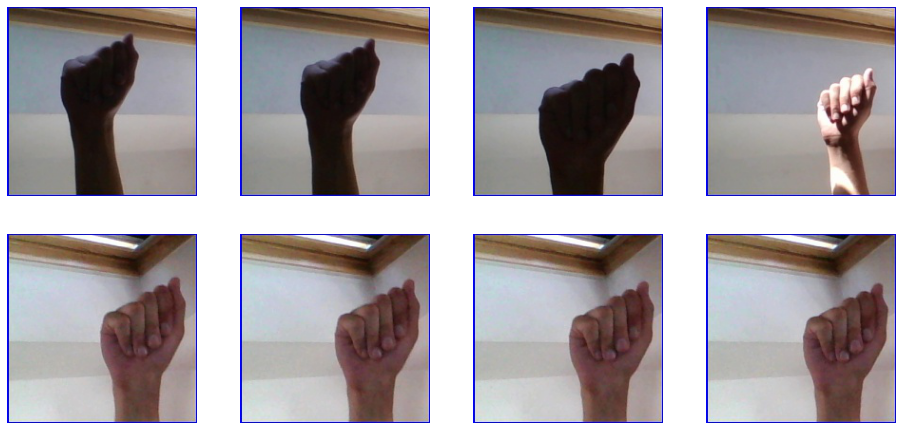

Image of alphabet A


In [4]:
# Showing random train images.

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random

random_column = random.choice(list(dataset.columns))
random_image_path = [i for i in list(dataset.loc[:7, random_column])]

#parameters for our graph, we will output image in a 4x4 configuration
nrows = 4
ncols = 4

#index for iterating
pic_index = 0

#setup matplotlib fig and size it to fit 4x4 img
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i, img_path in enumerate(random_image_path):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') #disable grid lines
    
    img = mpimg.imread(img_path)
    plt.imshow(img) 

plt.show()
print('Image of alphabet ' + random_column)

# Generate dataset coordinates using MediaPipe

In [5]:
file_list = {}

# Adjust how many dataset you want to create
target_success = 3000

# Take data in specified amount for creating dataset (make process faster)
# Make sure amount +100 than target success
data = dataset.loc[:3000]

for idx in data:
    file_list[idx] = data[idx].values

In [6]:
# Creating dataset header

landmarks = ['class']
for val in range(1, 22):
#     landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val)]
    landmarks += ['x{}'.format(val), 'y{}'.format(val)]
    
with open('hand_dataset.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [7]:
# Initialize mediapipe hand

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [8]:
with mp_hands.Hands( static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
        
    for idx, files in file_list.items():
        success = 0
        
        for file in files : 
            # Read an image, flip it around y-axis for correct handedness output (see
            # above).
            image = cv2.flip(cv2.imread(file), 1)
            # Convert the BGR image to RGB before processing.
            results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            
            if success < target_success:
                try :
                    # Extract Hand landmarks

                    for hand_landmark in results.multi_hand_landmarks:
                        right_hand = hand_landmark.landmark

#                     right_hand_row = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in right_hand]).flatten())
                    right_hand_row = list(np.array([[landmark.x, landmark.y] for landmark in right_hand]).flatten())

                    # Concate rows
                    row = right_hand_row

                    # Append class name 
                    row.insert(0, file.split('\\')[2])

                    # Export to CSV
                    with open('hand_dataset.csv', mode='a', newline='') as f:
                        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                        csv_writer.writerow(row) 
                        
                    success += 1
                    
                except :
                    pass
    
                # Print handedness and draw hand landmarks on the image.

#                 print('Handedness:', results.multi_handedness)
#                 if not results.multi_hand_landmarks:
#                   continue
#                 image_height, image_width, _ = image.shape
#                 annotated_image = image.copy()
#                 for hand_landmarks in results.multi_hand_landmarks:
#                   print('hand_landmarks:', hand_landmarks)
#                   print(
#                       f'Index finger tip coordinates: (',
#                       f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
#                       f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
#                   )
#                   mp_drawing.draw_landmarks(
#                       annotated_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

#                 if not os.path.exists('tmp'):
#                     os.mkdir('./tmp')

#                 cv2.imwrite('./tmp/' + file.split('\\')[2] + str(idx) + '.png', cv2.flip(annotated_image, 1))
            else :
                break